# Build and Simulate Group Model

## Load Tools

In [1]:
# Load from external libraries
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import seaborn as sns
from copy import deepcopy

# Load from the Standard Library
import random
import itertools
from collections import defaultdict

## Build Groups
( Can jump to ***Build Network*** if a *.json* file was previously saved. )

### Construct Nodes with Age Labels

In [2]:
import myGroupNetwork

N = 20000 # Total Population

youngPercent = 0.15 # Percentage of each age group
adultPercent = 0.65
oldPercent = 1 - youngPercent - adultPercent # = 0.20

nYoung = int(youngPercent * N)
nMiddle = int(adultPercent * N)
nSenior = N - nYoung - nMiddle
data = myGroupNetwork.buildGroups(size={'Young': nYoung, 'Middle': nMiddle, 'Senior': nSenior})

### Add Groups

In [3]:
data.addGroup(groupType='CareHome', numUnits=N//300, size={'Middle':20, 'Senior': 30}, contactPercentage=.7)

In [4]:
data.addGroup(groupType='School', numUnits=10//300, size={'Young':50, 'Middle': 20}, contactPercentage=.7)

In [5]:
data.addGroup(groupType='Work', numUnits=N//20, size={'Middle': 12}, exclude=['CareHome','School'], contactPercentage=.4)

In [6]:
data.addGroup(groupType='Home', numUnits=N//5, size= 3 , exclude=['CareHome'], contactPercentage=1)

### Export Group Data

In [7]:
data.save( filename='output/network_data.json' )

## Build Network

Load groups and build network

In [8]:
import myGroupNetwork

filename = 'output/network_data.json'
model = myGroupNetwork.buildNetwork( filename )

Inspect the nodes:

In [9]:
N = len(model.graph.nodes)
for i in range(0, N, N//20): # List 20 nodes
    print(i ,model.graph.nodes[i])

0 {'AgeLevel': 'Young', 'Home': 3694}
1000 {'AgeLevel': 'Young', 'Home': 292}
2000 {'AgeLevel': 'Young'}
3000 {'AgeLevel': 'Middle'}
4000 {'AgeLevel': 'Middle', 'Work': 68}
5000 {'AgeLevel': 'Middle', 'Work': 957, 'Home': 1513}
6000 {'AgeLevel': 'Middle'}
7000 {'AgeLevel': 'Middle', 'Work': 618}
8000 {'AgeLevel': 'Middle', 'Home': 3910}
9000 {'AgeLevel': 'Middle', 'Work': 890, 'Home': 3860}
10000 {'AgeLevel': 'Middle', 'Work': 435, 'Home': 2298}
11000 {'AgeLevel': 'Middle', 'Work': 763}
12000 {'AgeLevel': 'Middle', 'Work': 449, 'Home': 2258}
13000 {'AgeLevel': 'Middle'}
14000 {'AgeLevel': 'Middle', 'Work': 974}
15000 {'AgeLevel': 'Middle', 'Work': 134}
16000 {'AgeLevel': 'Senior'}
17000 {'AgeLevel': 'Senior', 'CareHome': 45}
18000 {'AgeLevel': 'Senior'}
19000 {'AgeLevel': 'Senior', 'Home': 1278}


Set parameters for the model

In [10]:
model.params['beta'] = .003
model.params['gammaI'] = .1
model.params['gammaA'] = .15
model.params['gammaRI'] = .2
model.params['gammaRI'] = .2
model.params['gammaD'] = .01

## Run Iteration

In [11]:
model.initialize( numCases=10 )
num_iter = 40
model.bunchIteration( num_iter )

Visualize the result:

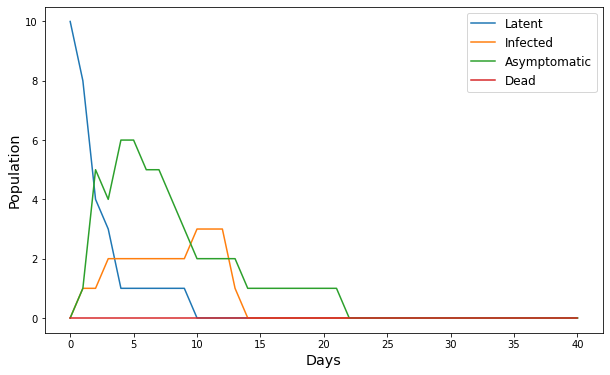

In [12]:
fig, ax = plt.subplots( figsize=(10,6) )
skipped = ['S','RI', 'RA']
for c in model.statusNames: # Drop S, RI and RA
    if c in skipped: continue
    ax.plot(model.trend[c], label=model.statusNames[c])
ax.legend( fontsize='large' )
ax.set_xlabel('Days', fontsize='x-large')
ax.set_ylabel('Population', fontsize='x-large')

filename = 'output/fig_trend'
savefig( filename + '.png' )
savefig( filename + '.pdf' )

## Multiple Runs

In [13]:
numRun = 5
multiTrend =  []
for iRun in tqdm(range(numRun)):
    model.initialize( numCases=10 )
    numIter = 40
    model.bunchIteration( numIter )
    multiTrend.append( model.trend )

100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


Visualization

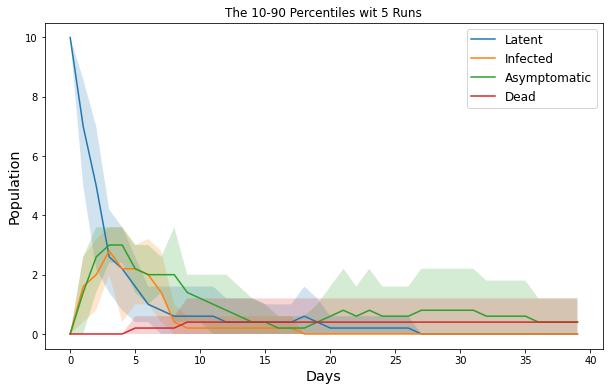

In [14]:
ave, upper, lower = (defaultdict(lambda: [0]*numIter) for _ in range(3))
percentile = 10
for j in range(numIter):
    for c in model.statusNames:
        if c in ['RI','RA']: continue
        data = [multiTrend[i][c][j] for i in range(numRun)]
        ave[c][j] = np.average(data)
        upper[c][j] = np.percentile(data,percentile)
        lower[c][j] = np.percentile(data,100-percentile)
fig, ax = plt.subplots( figsize=(10,6) )
days = list(range(numIter))
for c in model.statusNames:
    if c in ['S','RI','RA']: continue
    ax.plot(days, ave[c], label=model.statusNames[c])
    ax.fill_between(days, lower[c], upper[c], alpha=.2)
ax.legend( fontsize='large' )
ax.set_xlabel('Days', fontsize='x-large')
ax.set_ylabel('Population', fontsize='x-large')
ax.set_title(f'The {percentile}-{100-percentile} Percentiles wit {numRun} Runs')

filename = 'output/fig_trend_multi_run'
savefig( filename + '.png' )
savefig( filename + '.pdf' )

## Effects of Large Gathering

In [15]:
dayOfEvent = [5,6] # Big event days
numIter = 40
numRun = 7

numPeople = 400
contactPercentage = .6

nodesList = list(model.graph.nodes.keys())
multiTrend = []
for iRun in tqdm(range(numRun)):
    model.initialize( numCases=10 )
    for j in range(numIter):
        if j in dayOfEvent:
            participantsList = random.choices(nodesList, k=numPeople)
            edgeAll = list( itertools.combinations(participantsList,2) )
            edgeList = random.choices( edgeAll, k=int(len(edgeAll)*contactPercentage) )
            model.addContacts(edgeList, weight=1)
            model.iteration()
            model.addContacts(edgeList, weight=-1)
        else:
            model.iteration()
    multiTrend.append( model.trend )

100%|██████████| 7/7 [00:19<00:00,  2.82s/it]


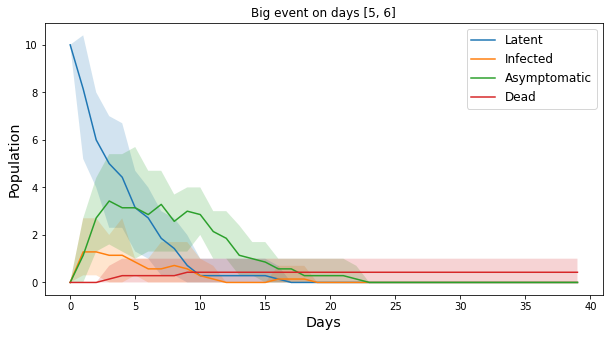

In [16]:
percentile = 5
ave, upper, lower = (defaultdict(lambda: [0]*numIter) for _ in range(3))
skipped = ['S','RI','RA']
for j in range(numIter):
    for c in model.statusNames:
        if c in skipped: continue
        data = [multiTrend[i][c][j] for i in range(numRun)]
        ave[c][j] = np.average(data)
        upper[c][j] = np.percentile(data,percentile)
        lower[c][j] = np.percentile(data,100-percentile)
fig, ax = plt.subplots( figsize=(10,5) )
days = list(range(numIter))
for s, sName in model.statusNames.items():
    if s in skipped: continue
    ax.plot(days, ave[s], label=sName)
    ax.fill_between(days, lower[s], upper[s], alpha=.2)
ax.legend( fontsize='large' )
ax.set_xlabel('Days', fontsize='x-large')
ax.set_ylabel('Population', fontsize='x-large')
ax.set_title(f'Big event on days {dayOfEvent}')

filename = 'output/fig_large_gathering'
savefig( filename + '.png' )
savefig( filename + '.pdf' )

## Effects of Family Gathering

In [17]:
start = 5 # start day of family gathering
end = 10 # end day of family gathering
numIter = 50
numRun = 7
numFamily = 60
numPeopleEach = 20
nodeList = list(model.graph.nodes.keys())

model.params['beta'] = .005

draw = random.choices( nodeList, k = numFamily * numPeopleEach )
count = 0
edgeList = []
for i in range(numFamily):
    members = draw[count:count+numPeopleEach]
    edgeList += list( itertools.combinations( members, 2) )
    count += numPeopleEach

multiTrend =  []
for iRun in tqdm(range(numRun)):
    model.initialize( numCases=10 )
    for j in range(numIter):
        if j == start:
            model.addContacts(edgeList, weight=1)
        model.iteration()
        if j == end:
            model.addContacts(edgeList, weight=-1)
    multiTrend.append( model.trend )

100%|██████████| 7/7 [00:19<00:00,  2.73s/it]


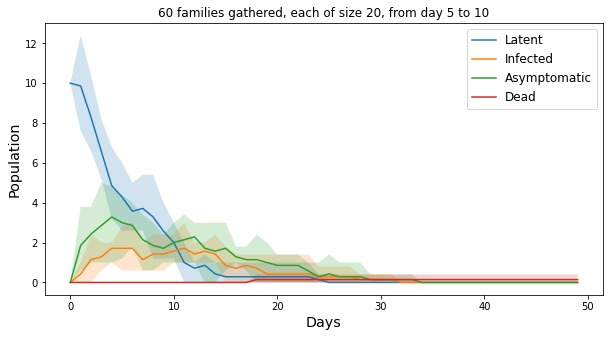

In [18]:
percentile = 10
ave, upper, lower = (defaultdict(lambda: [0]*numIter) for _ in range(3))
skipped = ['S','RI','RA']
for j in range(numIter):
    for c in model.statusNames:
        if c in skipped: continue
        data = [multiTrend[i][c][j] for i in range(numRun)]
        ave[c][j] = np.average(data)
        upper[c][j] = np.percentile(data,percentile)
        lower[c][j] = np.percentile(data,100-percentile)
fig, ax = plt.subplots( figsize=(10,5) )
days = list(range(numIter))
for s, sName in model.statusNames.items():
    if s in skipped: continue
    ax.plot(days, ave[s], label=sName)
    ax.fill_between(days, lower[s], upper[s], alpha=.2)
ax.legend( fontsize='large' )
ax.set_xlabel('Days', fontsize='x-large')
ax.set_ylabel('Population', fontsize='x-large')
ax.set_title(f'{numFamily} families gathered, each of size {numPeopleEach}, from day {start} to {end}')

filename = 'output/fig_family_gathering'
savefig( filename + '.png' )
savefig( filename + '.pdf' )

## Effects of Importation

In [19]:
modelOld = model
numVisitorsPerDay = [10, 20, 30, 40]
N = len(numVisitorsPerDay)
newInfectiousRate = .005
contact = 6
quarantine = 0
numIter = 40
numRun = 7
endSizes = [[0] * numRun for _ in range(N)]
for j in tqdm(range(N)):
    numV = numVisitorsPerDay[j]
    model = deepcopy(modelOld)
    for iRun in range(numRun):
        model.initialize( numCases=10 )
        for _ in range(numIter):
            model.addNodes(numV, newInfectiousRate, contact, quarantine)
            model.iteration()
        for c in ['L','I','A']:
            endSizes[j][iRun] += model.trend[c][-1]
model = modelOld

100%|██████████| 4/4 [01:34<00:00, 23.60s/it]


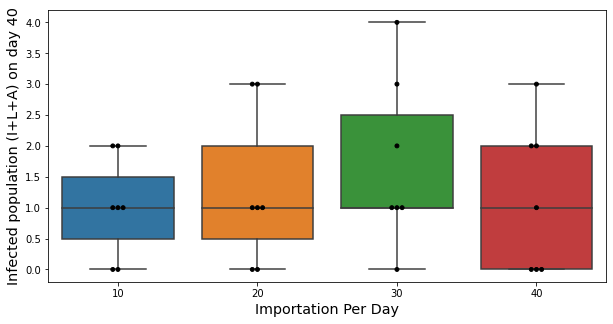

In [20]:
fig, ax = plt.subplots( figsize=(10,5) )
sns.boxplot(data=endSizes, ax=ax)
sns.swarmplot(data=endSizes, ax=ax, size=4, color='k', linewidth=.9)
plt.xticks(plt.xticks()[0], numVisitorsPerDay)
ax.set_xlabel('Importation Per Day', fontsize='x-large')
ax.set_ylabel(f'Infected population (I+L+A) on day {numIter}', fontsize='x-large')

filename = 'output/fig_importation'
savefig( filename + '.png' )
savefig( filename + '.pdf' )